<div align="right"><em>Машинне навчання. Лабораторний практикум</em></div>

# Лабораторна робота №3
## Дерева рішень в задачах класифікації

---

## Завдання

Необхідно:
- розібратися з тим, як працює дерево рішень;
- навчити і налаштувати дерева в задачі класифікації на даних про серцево-судинні захворювання;
- дати відповіді (з написанням коду) на всі запитання сформульовані в лабораторній роботі. 

## Виконання завдання

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

### 1. Функції для розрахунку ентропії та приросту інформації

Приклад для перевірки: 9 синіх кульок і 11 жовтих. Нехай кулька знаходиться в стані "1", якщо вона синя і "0" – якщо вона жовта.

![png](../img/entropy_1.png)

In [5]:
balls = [1 for i in range(9)] + [0 for i in range(11)]
balls

[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Далі нехай кульки розбиваються на 2 групи

![png](../img/entropy_2.png)

In [6]:
# дві групи
balls_left  = [1 for i in range(8)] + [0 for i in range(5)] # 8 синіх і 5 жовтих
balls_right = [1 for i in range(1)] + [0 for i in range(6)] # 1 синя і 6 жовтих

**Реалізуйте функцію для розрахунку ентропії Шеннона.**

In [18]:
from math import log

def entropy(a_list):
    general_count = len(a_list)
    entropy = 0
    for el in set(a_list):
        prop_i = a_list.count(el) / general_count
        entropy -= prop_i * np.log2(prop_i)
    return entropy

Перевірка

In [19]:
print(entropy(balls)) # 9 синіх і 11 жовтих
print(entropy(balls_left)) # 8 синіх і 5 жовтих
print(entropy(balls_right)) # 1 синя і 6 жовтих
print(entropy([1,2,3,4,5,6])) # ентропія грального кубика з незміщеним центром ваги

# 0.96
# 2.58

0.9927744539878083
0.9612366047228759
0.5916727785823275
2.584962500721156


**Запитання 1. Чому дорівнює ентропія стану, заданого списком balls_left?**

**Запитання 2. Чому дорівнює ентропія грального кубика з незміщеним центром ваги?**

In [26]:
# розрахунок приросту інформації

def information_gain(root, left, right):
    ''' root - початковий набір даних, left і right два розбиття початкового набору '''
    s_0 = entropy(root)
    general_count = len(root)
    groups = [left, right]
    groups_entropy_sum = 0
    for g in groups:
        groups_entropy_sum -= (len(g) / general_count) * entropy(g)
    ig_q = s_0 + groups_entropy_sum
    return ig_q


**Запитання 3. Який приріст інформації при розбитті вибірки на balls_left і balls_right?**

In [29]:
# Ваш код тут
information_gain(balls, balls_left, balls_right)
# Зараз показник приросту інформації вказує 0.16 (Для порівняння, для повної групи він рівний log2_1 = 0)

np.float64(0.16088518841412436)

### 2. Побудова дерева рішень для прогнозування наявності серцево-судинних захворювань

#### Завдання
Необхідно дати відповіді (з написанням коду) на запитання щодо набору даних про серцево-судинні захворювання. Дані збережені у файлі *../data/bootcamp5.csv*.

#### Проблема

Прогнозування наявності або відсутності серцево-судинних захворювань (ССЗ), використовуючи результати обстеження пацієнта.

#### Опис даних

Набір даних сформований на основі реальної інформації про серцево-судинні захворювання пацієнтів і містить ознаки, що можна розбити на 3 групи:
- *Об'єктивні*: фактична інформація;
- *Обстеження*: результати медичного огляду;
- *Суб’єктивні*: інформація, надана пацієнтом.

|           Ознака          |    Група    | Назва змінної | Тип значення                                  |
|:------------------------- |:----------- |:------------- |:--------------------------------------------- |
| Вік                       | Об'єктивні  | age           | int (дні)                                     |
| Зріст                      | Об'єктивні  | height        | int (см)                                      |
| Вага                      | Об'єктивні  | weight        | float (кг)                                    | 
| Стать                     | Об'єктивні  | gender        | категоріальний код                            |
| Верхній артеріальний тиск | Обстеження  | ap_hi         | int                                           |
| Нижній артеріальний тиск  | Обстеження  | ap_lo         | int                                           |
| Холестерин                | Обстеження  | cholesterol   | 1: норма, 2: вище норми, 3: значно вище норми |
| Глюкоза                   | Обстеження  | gluc          | 1: норма, 2: вище норми, 3: значно вище норми |
| Куріння                   | Суб’єктивні | smoke         | binary                                        |
| Вживання алкоголю         | Суб’єктивні | alco          | binary                                        |
| Фізична активність        | Суб’єктивні | active        | binary                                        |

Цільова ознака (яку цікаво буде прогнозувати): наявність серцево-судинних захворювань за результатами класичного лікарського огляду (**cardio**).

Всі показники отримані на момент огляду.

### Виконання

In [80]:
df = pd.read_csv('../data/bootcamp5.csv', sep=';', index_col=0)
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,1,168,62.0,110,80,1,1,0,0,1,0
1,20228,2,156,85.0,140,90,3,1,0,0,1,1
2,18857,2,165,64.0,130,70,3,1,0,0,0,1
3,17623,1,169,82.0,150,100,1,1,0,0,1,1
4,17474,2,156,56.0,100,60,1,1,0,0,0,0


Зробіть наступні перетворення ознак:

- створіть "вік у роках", поділивши вік на 365.25 і застосувавши функцію `floor` ($\lfloor{x}\rfloor$ – це найбільше ціле число, що не перевищує $x$);
- створіть 3 бінарні ознаки на основі `cholesterol`; 
- створіть 3 бінарні ознаки на основі `gluc`.
<br>Два останні пункти можна реалізувати за допомогою методу [pandas.get_dummies](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html). Немає потреби у використанні початкових ознак `cholesterol` та `gluc` після кодування (видаліть їх).

In [147]:
# Ваш код тут
#df["age_years"] = np.floor(df["age"] / 365)
# df = pd.get_dummies(df, columns=["cholesterol", "gluc"])
# df.drop(["cholesterol", "gluc"], axis = 1, inplace= True)

Розділіть дані на навчальну та відкладену частини у пропорції 7/3, використовуючи `sklearn.model_selection.train_test_split` з `random_state=17`.

In [117]:
# Ваш код тут
# X_train, X_valid, y_train, y_valid = ...

y = df['cardio']
x = df.drop(['cardio', "age"], axis=1)
X_train, X_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.3, random_state = 17)
print(x)

       gender  height  weight  ap_hi  ap_lo  smoke  alco  active  age_years  \
id                                                                            
0           1     168    62.0    110     80      0     0       1       50.0   
1           2     156    85.0    140     90      0     0       1       55.0   
2           2     165    64.0    130     70      0     0       0       51.0   
3           1     169    82.0    150    100      0     0       1       48.0   
4           2     156    56.0    100     60      0     0       0       47.0   
...       ...     ...     ...    ...    ...    ...   ...     ...        ...   
99993       1     168    76.0    120     80      1     0       1       52.0   
99995       2     158   126.0    140     90      0     0       1       61.0   
99996       1     183   105.0    180     90      0     1       0       52.0   
99998       2     163    72.0    135     80      0     0       0       61.0   
99999       2     170    72.0    120     80      0  

Навчіть дерево рішень на наборі даних (`X_train`, `y_train`) з **максимальною глибиною рівною 3** і `random_state=17`. Візуалізуйте це дерево. Бібліотека `sklearn` дозволяє вивести дерево у форматі `.dot`, який може використовуватися Graphviz для візуалізації. Graphviz - це пакет інструментів з відкритим кодом для візуалізації графів описаних мовою [DOT](https://uk.wikipedia.org/wiki/%D0%9C%D0%BE%D0%B2%D0%B0_DOT). 
Як побудувати дерево рішень, альтернативні варіанти:
 1. Встановити Graphviz та pydotpus самостійно.
 2. Простий спосіб (без pydotplus та Graphviz): 
  - виконати код ``` dot_data = export_graphviz(your_tree); print(dot_data) ``` 
  - перейти за адесою http://www.webgraphviz.com, вставити виведений рядок коду графа (digraph Tree {...) та створити відповідне зображення.

In [116]:
# Ваш код тут
# dot_data = export_graphviz(your_tree, feature_names=...)
# print(dot_data)
from sklearn.tree import plot_tree
def tree_graph_to_png(tree, feature_names, png_file_to_save):  
    plt.figure()
    plot_tree(tree, feature_names=feature_names, 
                                     filled=True)  
    plt.savefig(png_file_to_save)
    plt.close()

tree = DecisionTreeClassifier(max_depth=3, random_state=17)
tree.fit(X_train, y_train)

tree_graph_to_png(tree=tree, feature_names=['gender','height','weight','ap_hi','ap_lo','smoke,''alco','active','age_years','cholesterol_1','cholesterol_2','cholesterol_3','gluc_1','gluc_2','gluc_3'], png_file_to_save='../img/topic3_decision_tree1.png')
# 2. age, ap_hi, chol=3 (на картинці не правильно демонструються написи, можливо через плутанину з індексами, я перевірив через інтернет-ресурс)


**Запитання 4. Які 3 ознаки використовуються для прогнозування у створеному дереві рішень?**

1. age, ap_lo, chol=1
2. age, ap_hi, chol=3

3. smoke, age, gender
4. alco, weight, gluc=3

Зробіть прогноз для відкладених даних (`X_valid`, `y_valid`) за допомогою навченого дерева рішень. Обчисліть частку правильних відповідей (accuracy).

In [118]:
# Ваш код тут
tree_pred = tree.predict(X_valid)
accuracy_score(y_valid, tree_pred) 

0.7212857142857143

Встановіть глибину дерева за допомогою крос-валідації на наборі даних (`X_train`, `y_train`) для підвищення якості моделі. Використовуйте `GridSearchCV` з `cv=5`. Зафіксуйте `random_state=17` і змінюйте `max_depth` від 2 до 10.

In [121]:
tree_params = {'max_depth': list(range(2, 11))}

tree_grid = GridSearchCV(tree, tree_params, cv=5, n_jobs=-1, verbose=True) # Ваш код тут
tree_grid.fit(X_train, y_train)



Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=3, random_state=17),
             n_jobs=-1, param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
             verbose=True)

Побудуйте графік, щоб показати, як змінюється середня частка правильних відповідей зі зміною `max_depth` на крос-валідації.

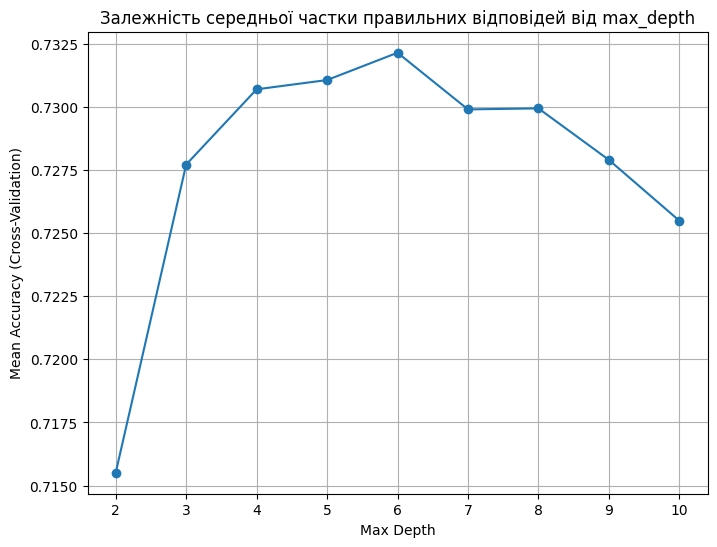

In [122]:
# Ваш код тут
depths = tree_grid.param_grid['max_depth']
mean_test_scores = tree_grid.cv_results_['mean_test_score']

# Побудова графіку
plt.figure(figsize=(8, 6))
plt.plot(depths, mean_test_scores, marker='o')
plt.xlabel('Max Depth')
plt.ylabel('Mean Accuracy (Cross-Validation)')
plt.title('Залежність середньої частки правильних відповідей від max_depth')
plt.grid(True)
plt.show()

Виведіть найкраще значення `max_depth`, для якого середнє значення метрики якості на крос-валідації досягає максимуму. Також обчисліть частку правильних відповідей на відкладених даних. Це можна зробити за допомогою навченого екземпляра класу `GridSearchCV`.

In [124]:
# Ваш код тут
tree_grid.best_params_, tree_grid.best_score_

({'max_depth': 6}, np.float64(0.7321428571428572))

Обчисліть ефект `GridSearchCV`: (acc2 - acc1) / acc1 * 100%, де acc1 і acc2 – частки правильних відповідей на відкладених даних до і після налаштування `max_depth` з `GridSearchCV` відповідно.

In [129]:
# Ваш код тут
acc1 = accuracy_score(y_valid, tree_pred) 
acc2 = tree_grid.best_score_
eff = ((acc2 - acc1) / acc1) * 100
eff
# 1.5%
#`GridSearchCV` збільшив частку правильних відповідей на відкладених даних **більше** ніж на 1%
# Існує локальний максимум частки правильних відповідей для побудованої кривої валідації

np.float64(1.5052485640720992)

**Запитання 5. Виберіть усі правильні твердження.**

- Існує локальний максимум частки правильних відповідей для побудованої кривої валідації
- `GridSearchCV` збільшив частку правильних відповідей на відкладених даних **більше** ніж на 1%
- Побудована крива валідації **не має** локального максимуму частки правильних відповідей
- `GridSearchCV` збільшив частку правильних відповідей на відкладених даних **менше** ніж на 1%

Подивіться на [шкалу SCORE](https://www.escardio.org/Education/Practice-Tools/CVD-prevention-toolbox/SCORE-Risk-Charts) для розрахунку ризику смерті від серцево-судинного захворювання в найближчі 10 років:
<img src='../img/SCORE.png' width=70%>

Давайте створимо нові ознаки відповідно до цього рисунку:
- Вік: $age \in [40,50), age \in [50,55), age \in [55,60), age \in [60,65)$ (4 ознаки).
- Верхній артеріальний тиск: $ap\_hi \in [120,140), ap\_hi \in [140,160), ap\_hi \in [160,180)$ (3 ознаки).

Якщо значення віку або артеріального тиску не потрапляють ні в один з інтервалів, то всі бінарні ознаки будуть дорівнювати нулю.

Додайте ознаку `smoke`.

Додайте ознаки `cholesterol` та `gender`. Перетворіть `cholesterol` на 3 бінарні ознаки відповідно до 3-х унікальних значень (`cholesterol`=1, `cholesterol`=2 і `cholesterol`=3). Перетворіть `gender` з 1 і 2 на 0 і 1. Краще перейменувати цю ознаку на `male` (0 – жінка, 1 – чоловік). В загальному, це робиться за допомогою [`sklearn.preprocessing.LabelEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html), але тут, у випадку лише двох унікальних значень, не потрібно.

Нарешті, дерево рішень будується за допомогою цих 12 бінарних ознак (виключити всі ознаки, які ми мали до цього).

Створіть дерево рішень з обмеженням `max_depth=3` і навчайте його на всіх навчальних даних. Використовуйте клас `DecisionTreeClassifier` з фіксованим `random_state=17`. Всі інші параметри (крім `max_depth` та `random_state`) повинні бути залишені за замовчуванням.

**Запитання 6. Яка бінарна ознака є найважливішою для виявлення ССЗ (тобто вона розміщується в корені дерева)?**

- Верхній артеріальний тиск від 160 до 180 (мм рт.ст.)
- Рівень холестерину == 3
- Верхній артеріальний тиск від 140 до 160 (мм рт.ст.)
- Вік від 50 до 55 (років)
- Курить/не курить
- Вік від 60 до 65 (років)

In [156]:
# Ваш код тут
df['age_40_50'] = np.where((df['age_years'] >= 40) & (df['age_years'] < 50), 1, 0)
df['age_50_55'] = np.where((df['age_years'] >= 50) & (df['age_years'] < 55), 1, 0)
df['age_55_60'] = np.where((df['age_years'] >= 55) & (df['age_years'] < 60), 1, 0)
df['age_60_65'] = np.where((df['age_years'] >= 60) & (df['age_years'] < 65), 1, 0)
df['ap_hi_120_140'] = np.where((df['ap_hi'] >= 120) & (df['ap_hi'] < 140), 1, 0)
df['ap_hi_140_160'] = np.where((df['ap_hi'] >= 140) & (df['ap_hi'] < 160), 1, 0)
df['ap_hi_160_180'] = np.where((df['ap_hi'] >= 160) & (df['ap_hi'] < 180), 1, 0)
new_df = df[['age_40_50', 'age_50_55', 'age_55_60', 'age_60_65',
             'ap_hi_120_140', 'ap_hi_140_160', 'ap_hi_160_180', 'gender', "smoke", 'cholesterol_1', 'cholesterol_2',
       'cholesterol_3']]
X_train, X_valid, y_train, y_valid = train_test_split(new_df, y, test_size = 0.3, random_state = 17)
tree = DecisionTreeClassifier(max_depth=3, random_state=17)
tree.fit(X_train, y_train)
dot_data = export_graphviz(tree)

# Bерхній артеріальний тиск від 140 до 160 (мм рт.ст.)
tree_pred = tree.predict(X_valid)
accuracy_score(y_valid, tree_pred) 


0.704047619047619